# Anomaly detection
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/anomaly_detection.ipynb)


## Setup

In [ ]:
pip install ydf ucimlrepo scikit-learn umap-learn plotly -U -q

## What is Anomaly Detection?

**Anomaly detection** is a type of unsupervised learning that focuses on identifying rare items, events, or observations that differ significantly from the majority of the data. These outliers are often called "anomalies." This technique is powerful because it doesn't require labeled examples of anomalies during training.

For instance, anomaly detection can be used for:

*   **Fraud detection**: Identifying unusual credit card transactions.
*   **Intrusion detection**: Spotting abnormal network traffic.
*   **Quality control**: Finding defective products on a manufacturing line.

Using decision forests for anomaly detection is a simple yet effective method for tabular data. The model assigns an **anomaly score** to each data point, ranging from 0 (normal) to 1 (abnormal). A key advantage of this approach is that you can use the same interpretability tools available for other decision forest models to understand why a particular data point was flagged as an anomaly.

In this context, labeled data isn't used for training but is valuable for evaluating the model's performance and ensuring it can successfully identify known types of anomalies.


In this tutorial, we will train an anomaly detection model on the UCI Covertype dataset. Our goal is to see if the model can distinguish between a common cover type (Spruce/Fir) and a rare one (Cottonwood/Willow) without being told which is which.

In [22]:
#@title Load libraries

import ydf                           # For the anomaly detection model
import pandas as pd                  # For data manipulation
from sklearn import metrics          # To compute the AUC score
import matplotlib.pyplot as plt      # For plotting
import seaborn as sns                # For enhanced plotting
import umap                          # For dimensionality reduction and visualization

# Disable a common Pandas warning
pd.options.mode.chained_assignment = None

## Prepare dataset

First, we download the "Covertype" dataset from the UCI Machine Learning Repository. This dataset describes various geographic attributes for parcels of land.

In [5]:
# https://archive.ics.uci.edu/dataset/31/covertype
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
col_names = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + \
[f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']

raw_dataset = pd.read_csv(url, header=None, names=col_names, compression='gzip')

Next, we'll select the features we are interested in and convert the numeric Cover_Type labels into human-readable text.

In [6]:
dataset = raw_dataset.copy()

# Features of interest
features = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
            "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
            "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
            "Horizontal_Distance_To_Fire_Points"]
dataset = dataset[features + ["Cover_Type"]]

# Covert type as text
dataset["Cover_Type"] = dataset["Cover_Type"].map({
    1: "Spruce/Fir",
    2: "Lodgepole Pine",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
})

dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,Aspen
1,2590,56,2,212,-6,390,220,235,151,6225,Aspen
2,2804,139,9,268,65,3180,234,238,135,6121,Lodgepole Pine
3,2785,155,18,242,118,3090,238,238,122,6211,Lodgepole Pine
4,2595,45,2,153,-1,391,220,234,150,6172,Aspen


For our first model, we will create a "filtered dataset" that only contains examples of "Spruce/Fir" and "Cottonwood/Willow".

In [7]:
filtered_dataset = dataset[dataset["Cover_Type"].isin(["Spruce/Fir", "Cottonwood/Willow"])]

As you can see below, the "Spruce/Fir" cover type is much more common than "Cottonwood/Willow", making the latter a natural candidate for an "anomaly".

In [8]:
filtered_dataset["Cover_Type"].value_counts()

,count
Cover_Type,
Spruce/Fir,211840
Cottonwood/Willow,2747


## Anomaly detection model

We'll use a popular decision forest algorithm for this task called **Isolation Forest**. We only need to provide the features to the learner.

In [9]:
model = ydf.IsolationForestLearner(features=features).train(filtered_dataset)

Train model on 214587 examples
Model trained in 0:00:00.653946


Now, let's use the trained model to generate anomaly scores for each example.

In [10]:
predictions = model.predict(filtered_dataset)
predictions[:5]

array([0.55090207, 0.5859458 , 0.51124185, 0.58818966, 0.47086298],
      dtype=float32)

A higher score suggests a higher likelihood of being an anomaly. Let's plot the distribution of these scores for both cover types. We expect to see that the model assigns higher scores to the rarer "Cottonwood/Willow" class.

The plot below shows that the two distributions are well-separated, indicating the model can effectively differentiate between the two cover types without using any labels.

**Note**: The distributions are normalized independently so that the smaller "Cottonwood/Willow" class is visible.

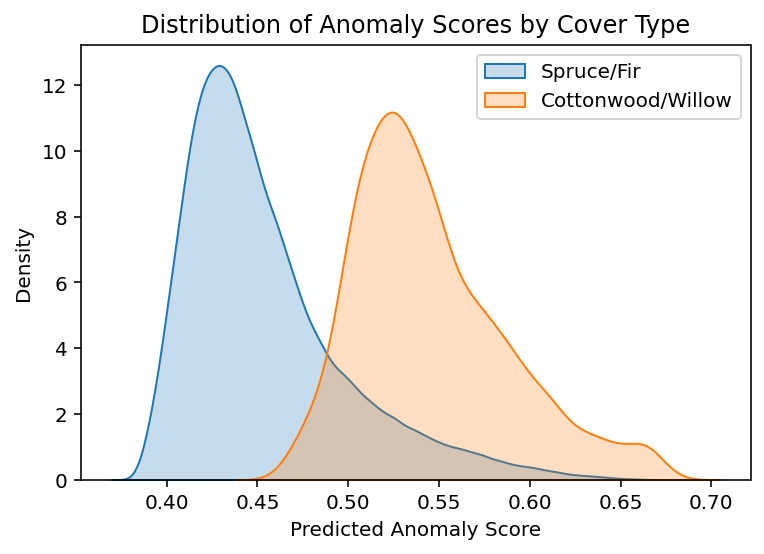

In [13]:
sns.kdeplot(predictions[filtered_dataset["Cover_Type"] == "Spruce/Fir"], label="Spruce/Fir", fill=True)
sns.kdeplot(predictions[filtered_dataset["Cover_Type"] == "Cottonwood/Willow"], label="Cottonwood/Willow", fill=True)
plt.xlabel("Predicted Anomaly Score")
plt.ylabel("Density")
plt.title("Distribution of Anomaly Scores by Cover Type")
plt.legend()
plt.show()

The AUC (Area Under the Curve) metric is often used to evaluate classification models. We can use it here to quantify how well our model's anomaly scores separate the two classes.

Since the model was trained without labels and we are evaluating it on the same static dataset, we don't need a separate test set. We can calculate the AUC on the entire filtered dataset.

In [14]:
# The "true" label is 1 if the type is Cottonwood/Willow (the anomaly), and 0 otherwise.
true_labels_for_auc = (filtered_dataset["Cover_Type"] == "Cottonwood/Willow")
auc_score = metrics.roc_auc_score(true_labels_for_auc, predictions)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9289


This high AUC score confirms that the model is excellent at separating the two cover types.

## Interpreting the Model

We can analyze the model to understand its logic. For example, the Partial Dependence Plot for `Elevation` shows that "normal" examples (Spruce/Fir) are typically found at altitudes between 2900 and 3300 meters. Values outside this range contribute to a higher anomaly score. Similar conclusions can be drawn for other features.

In [15]:
# Using a larger sampling fraction would yield more precise plots.
model.analyze(filtered_dataset, sampling=0.001)

[Warning] ANOMALY DETECTION models must be trained with a label for variable importance computation


We can also interpret individual predictions. Let's select the first "Cottonwood/Willow" example and see its anomaly score.

In [16]:
first_willow_example = filtered_dataset[filtered_dataset["Cover_Type"] == "Cottonwood/Willow"][:1]
first_willow_example

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
1988,2000,318,7,30,4,108,201,234,172,268,Cottonwood/Willow


In [17]:
model.predict(first_willow_example)

array([0.5587971], dtype=float32)

Now, let's analyze this prediction to see how each feature value contributed to the final score. The first plot shows that this example's low Elevation of ~2000m is highly unusual and is the primary reason for its high anomaly score. In contrast, its Hillshade values are considered relatively normal.

In [18]:
model.analyze_prediction(first_willow_example)

## Visualizing with Distances

Like other decision forest algorithms, an Isolation Forest defines an implicit distance metric between examples. We can compute this distance matrix, where a smaller value means two examples are more similar according to the model.

Let's compute the pairwise distances for the first 10,000 examples to keep the computation fast.

In [19]:
# Using more examples would create a more detailed visualization
distances = model.distance(filtered_dataset.iloc[:10000])
distances[:4, :4]

array([[0.        , 0.87666667, 0.62666667, 0.81666666],
       [0.87666667, 0.        , 0.91      , 0.29666665],
       [0.62666667, 0.91      , 0.        , 0.87333333],
       [0.81666666, 0.29666665, 0.87333333, 0.        ]], dtype=float32)

Finally, we can use a manifold learning algorithm like UMAP to project these complex distances into a 2D plot. The resulting visualization clearly shows that the model has learned to separate the two cover types into distinct clusters, even though it was never trained on the class labels.

/usr/local/google/home/my_user/my_venv/lib/python3.11/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


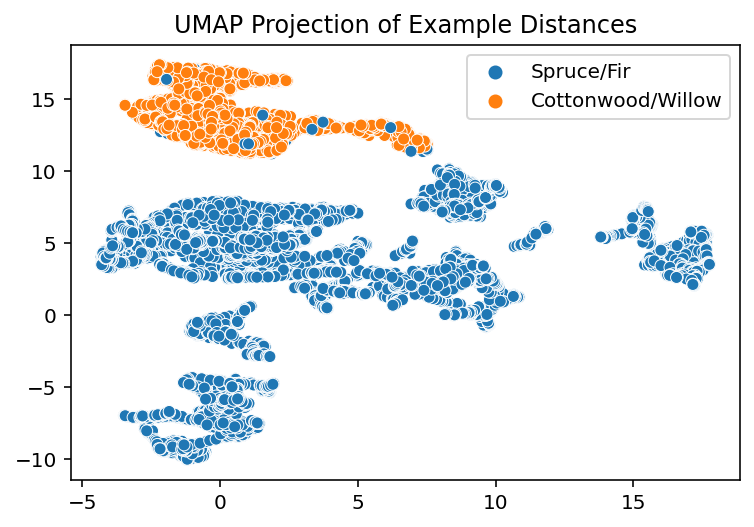

In [21]:
manifold = umap.UMAP(n_components=2, n_neighbors=10, metric="precomputed", random_state=42).fit_transform(distances)

sns.scatterplot(x=manifold[:, 0],
                y=manifold[:, 1],
                hue=filtered_dataset["Cover_Type"].iloc[:manifold.shape[0]])
plt.title("UMAP Projection of Example Distances")
plt.legend()
plt.show()